# Two-Level System Amplitude Noise

In this notebook, we set up a two-level qubit subject to a system Hamiltonian proportional to σz, and a driving Hamiltonian proportional to σx which is modulated by a cosine multiplied by a Gaussian.

Then, we fix all of the properties of the driving pulse and sweep amplitude to find which amplitude corresponds to a π pulse (i.e. a NOT gate). Finally, we add varying noise to this amplitude, and see how that affects gate fidelity, finding the maximum noise threshold to achieve some fidelity.

In [92]:
# imports

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import *
from scipy.optimize import curve_fit

In [93]:
# setup system
ψ0 = basis(2,0) # initial state
Ω = 5000 # Rabi frequency
H0 = Ω*sigmaz().unit() # system Hamiltonian
t = np.linspace(0, 10, 1000) # time steps

# state operators
ground = basis(2,0) * basis(2,0).dag()
excited = basis(2,1) * basis(2,1).dag()

In [94]:
# setup driving pulse
# A σx Hamiltonian varying in time: cosine-modulated Gaussian

H1 = sigmax().unit()
args = {"A":1, "μ":2, "σ":0.3, "Ω":Ω}

def H1_coeff_cg(t, args) -> float:

    A,μ,σ,Ω = args["A"], args["μ"], args["σ"], args["Ω"]

    return A * np.cos(Ω*(t-μ)) * (1/(σ*np.sqrt(2*pi))) * np.exp(-1 * (((t-μ)**2)/(2*(σ**2))))

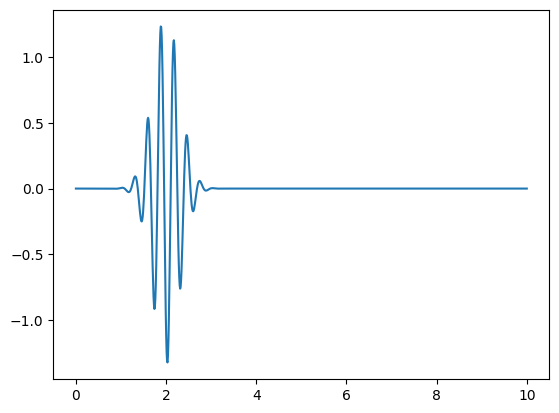

In [95]:
# visualise pulse

plt.plot(t, H1_coeff_cg(t, args))
plt.show()

In [96]:
# evolve system

# total Hamiltonian
# always has H0, and H1 times the coefficient function at different times is added to it
H = [H0, [H1, H1_coeff_cg]] 

# setup for mesolve
c_ops = [] # collapse operators
e_ops = [ground, excited] # expectation operators
prob_ground, prob_excited = [], []

# prep for sweeping amplitude
amplitudes = np.linspace(0, 7, 20)

# evolve
for i in amplitudes:
    args["A"] = i
    
    ψt = mesolve(H, ψ0, t, c_ops, e_ops, args)

    prob_ground.append(ψt.expect[0][-1])
    prob_excited.append(ψt.expect[1][-1])

Optimal amplitude for π pulse: 6.283044996998138


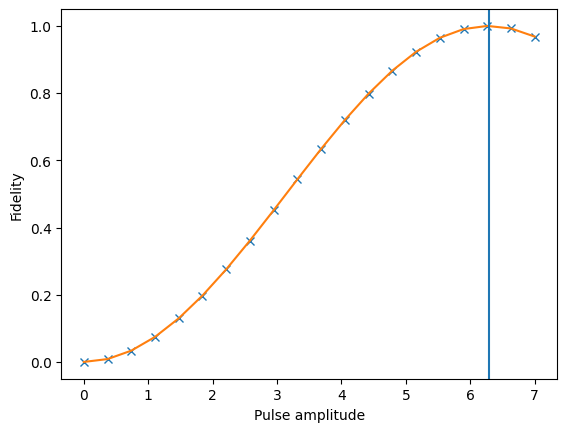

In [97]:
# extract optimal π pulse amplitude

def sinusoid(x,A,ω,φ,y0):
    return A*np.sin(ω*x+φ)+y0

A,ω,φ,y0 = curve_fit(sinusoid, amplitudes, prob_excited, [0.5, 0.1, 0, 0.5])[0]

optimal_amplitude = (pi/2 - φ)/ω
print("Optimal amplitude for π pulse: " + str(optimal_amplitude))

plt.plot(amplitudes, prob_excited, 'x')
plt.plot(amplitudes, sinusoid(amplitudes,A,ω,φ,y0))
plt.axvline(optimal_amplitude)
plt.ylabel("Fidelity")
plt.xlabel("Pulse amplitude")
plt.show()

Max noise threshold to achieve 0.99 fidelity is σ = 0.4020100502512563. 


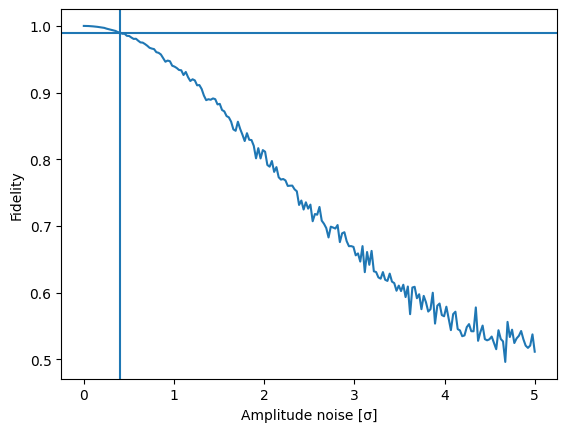

In [99]:
# add varying amounts of noise to this optimal amplitude and see how it affects the mean probability of getting to the excited state (i.e. the gate fidelity)

noise_σs = np.linspace(0, 5, 200)
fidelities = []

for σ in noise_σs:
    # create a 1000-element vector of amplitudes which are the optimal amplitude plus some gaussian noise with some stdev
    noisy_amplitudes = optimal_amplitude + np.random.normal(0, σ, 1000)

    # calculate the expected fidelity for each and average, add to the output list
    fidelities.append(np.average(sinusoid(noisy_amplitudes,A,ω,φ,y0)))

# calculate the maximum noise threshold to achieve some fidelity
fidelity_threshold = 0.99
max_noise_threshold = noise_σs[np.where(np.array(fidelities)>=fidelity_threshold)[0][-1]]

print("Max noise threshold to achieve " + str(fidelity_threshold) + " fidelity is σ = " + str(max_noise_threshold) + ". ")

plt.plot(noise_σs, fidelities)
plt.axhline(fidelity_threshold)
plt.axvline(max_noise_threshold)
plt.ylabel("Fidelity")
plt.xlabel("Amplitude noise [σ]")
plt.show()